In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

# Import Data

In [ ]:
#%cd ..

In [5]:
df = pd.read_csv("data/clustering/220516_gmm_clustered_fa_data_5cluster_tied.csv")

In [7]:
_, _, _, info_dict = get_cluster_input_data_new(fa_data=True)
behaviour_cols = info_dict['cluster_input_cols']
behaviour_cols

['F0_cautious_behaviour',
 'F1_perception_advice',
 'F2_applicability_usefullness_advice',
 'F3_behaviour_others',
 'F4_consequence_advice',
 'F5_no_contacts',
 'F6_perceived_threat']

# Daily Distribution

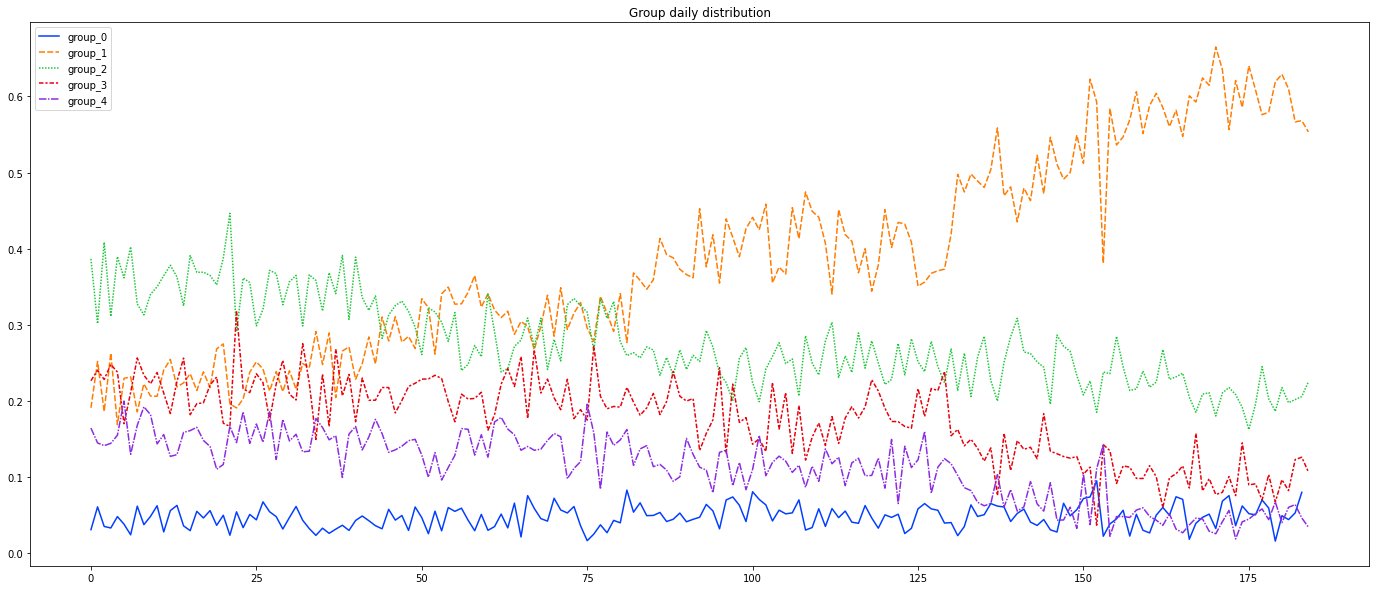

In [10]:
groups_percentage = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = groups_percentage[groups_percentage['date']==row['date']]['gender'].sum()
  return row['gender']/sum

groups_percentage['percentage'] = groups_percentage.apply(lambda x: normalize(x), axis=1)
groups_percentage['date'] = pd.to_datetime(groups_percentage['date'])
#groups_percentage.drop(columns='gender',inplace=True)
#fig = px.line(groups_percentage, x="date", y="percentage", color='group', title='Group daily distribution')
#fig.show()

df_groups_percentage = pd.DataFrame()
df_groups_percentage['date'] = groups_percentage['date'].unique()
group_cols = []
for group_nr in groups_percentage.group.unique().tolist():
  col_name = 'group_' + str(group_nr)
  df_groups_percentage[col_name] = groups_percentage[groups_percentage['group'] == group_nr].reset_index(drop=True)['percentage']
  group_cols.append(col_name)


fig, ax = plt.subplots(figsize=(24, 10))
sns.lineplot(data=df_groups_percentage, palette="bright", ax=ax)
plt.title('Group daily distribution')
plt.show()

# Filter interesting columns

In [ ]:
df_group_means = df[behaviour_cols + ['group']].copy()
df_group_means[behaviour_cols] = (df_group_means[behaviour_cols]-df_group_means[behaviour_cols].min())/(df_group_means[behaviour_cols].max()-df_group_means[behaviour_cols].min())
df_group_means.describe()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,F5_no_contacts,F6_perceived_threat,group
count,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000
mean,0.802909,0.707338,0.782465,0.615290,0.513018,0.261084,0.527123,1.939223
std,0.168546,0.201921,0.209502,0.226739,0.251729,0.283787,0.233263,1.096292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.708333,0.583333,0.708333,0.500000,0.333333,0.035714,0.333333,1.000000
50%,0.833333,0.747428,0.833333,0.615290,0.500000,0.142857,0.500000,2.000000
75%,0.937500,0.861111,0.958333,0.750000,0.666667,0.357143,0.666667,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [ ]:
df_group_means = df_group_means.groupby('group').mean().reset_index().transpose()
df_group_means.drop('group', inplace=True)
df_group_means.reset_index(inplace=True)
df_group_means['std'] = df_group_means.std(axis=1)
df_group_means = df_group_means.sort_values(by='std', ascending=False)
df_group_means.iloc[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,index,0,1,2,3,4,std
5,F5_no_contacts,0.165053,0.099752,0.105715,0.461494,0.895008,0.341271
2,F2_applicability_usefullness_advice,0.225088,0.814423,0.854508,0.786721,0.724364,0.259239
4,F4_consequence_advice,0.386782,0.702275,0.284564,0.509228,0.511660,0.156638
3,F3_behaviour_others,0.657893,0.656485,0.608252,0.582688,0.531312,0.053291
0,F0_cautious_behaviour,0.846505,0.834973,0.806070,0.762708,0.735273,0.047331
1,F1_perception_advice,0.626589,0.716137,0.742124,0.692026,0.650580,0.047110
6,F6_perceived_threat,0.508844,0.557850,0.486475,0.526126,0.535295,0.026972


# Answers Distributions

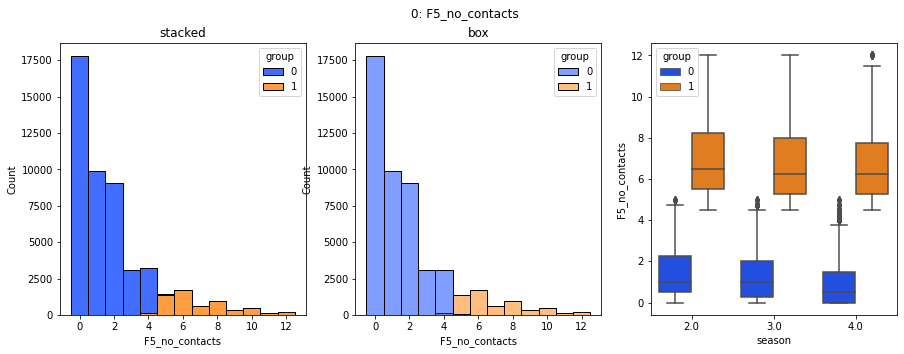

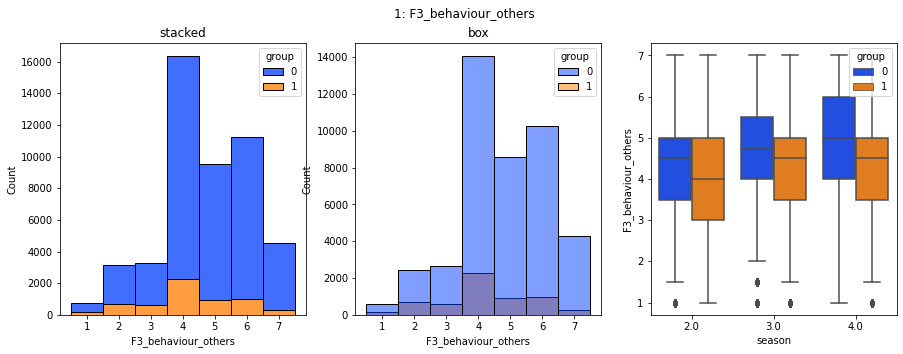

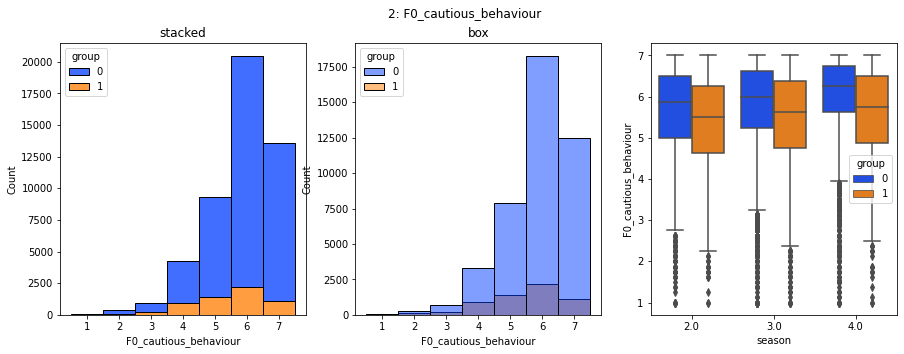

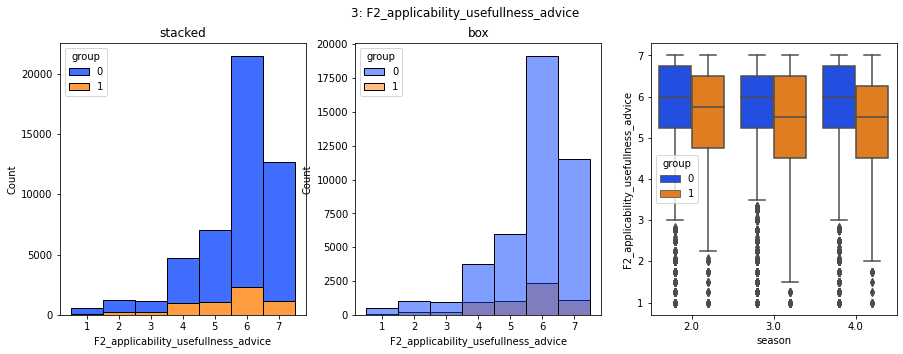

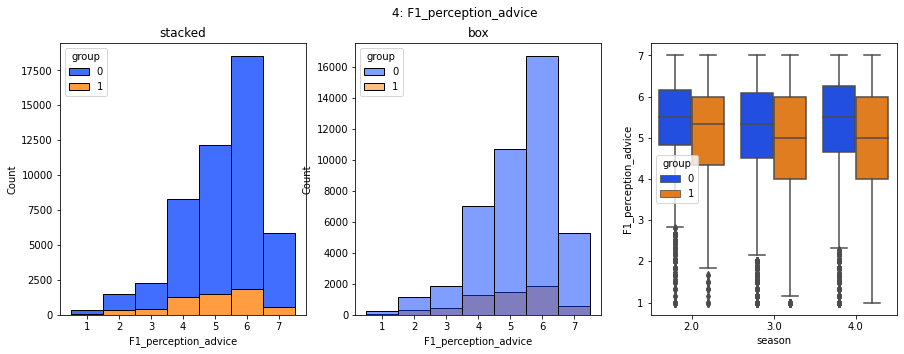

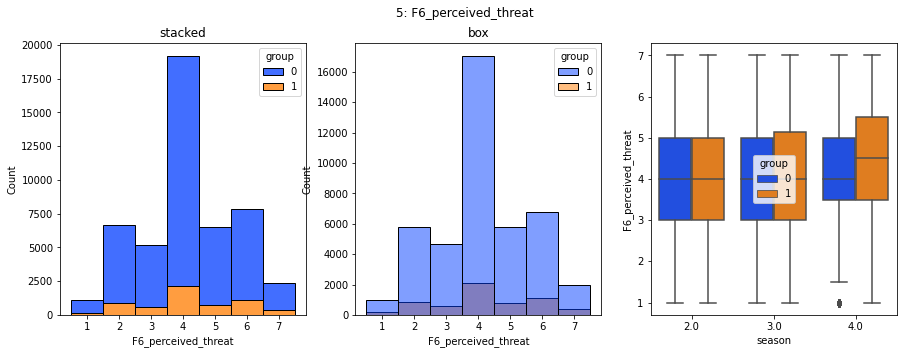

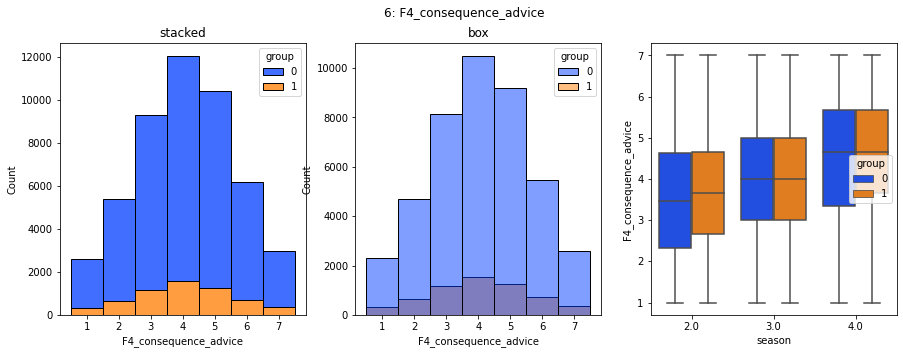

In [ ]:
for i, col in enumerate(top_cols):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    fig.suptitle(str(i)+': ' + col)
    sns.histplot(data=df.round(), x=col, hue="group", discrete=True, multiple="stack",ax=axes[0], palette='bright')
    axes[0].set_title('stacked')
    sns.histplot(data=df.round(), x=col, hue="group", discrete=True,ax=axes[1], palette='bright')
    axes[1].set_title('transparent')
    sns.boxplot(x="season", y=col, hue="group",data=df, ax=axes[2], palette='bright')
    axes[1].set_title('box')
    plt.show()

# Plot specific answers

## Create GIF

SystemError: ignored

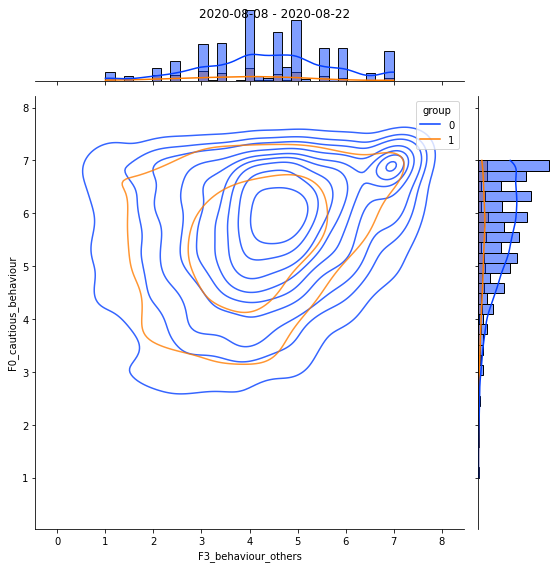

In [ ]:
"""df_timeframe = df.copy()
df_timeframe['date'] = pd.to_datetime(df_timeframe['date'])

plt.ioff()
for nr_weeks in range(52):
  dt_start_temp = df_timeframe.date.min() + timedelta(days=7) * nr_weeks
  dt_end_temp = dt_start_temp + timedelta(days=14)
  time_window = (df_timeframe['date'] > dt_start_temp) & (df_timeframe['date'] < dt_end_temp)
  df_timeframe_temp = df_timeframe[time_window]


  g = sns.JointGrid(data=df_timeframe_temp, x=top_cols[1], y=top_cols[2], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
  g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot #kdeplot
  g.plot_marginals(sns.histplot, kde=True) #or kdeplot
  fig = g.fig
  fig.suptitle(dt_start_temp.strftime("%Y-%m-%d") + ' - ' + dt_end_temp.strftime("%Y-%m-%d"))
  fig.savefig("gif_creation/images/out_"+dt_start_temp.strftime("%Y_%m_%d") + ".png")
  plt.close(fig)"""

In [ ]:
"""# Create GIF
images = []
path = 'gif_creation/images/'

for filename in os.listdir(path):
  images.append(imageio.imread(path+filename))
  os.remove(path+filename)
imageio.mimsave('gif_creation/gmm_grouped.gif', images, duration=0.5)"""

## Plot

In [ ]:
df_sample = df.sample(20000)

In [ ]:
start = '2020-11-01'
end = '2020-11-14'
df_sample.date = pd.to_datetime(df_sample.date)
in_range = (df_sample.date > start) & (df_sample.date < end)
df_sample_timewindow = df_sample[in_range]

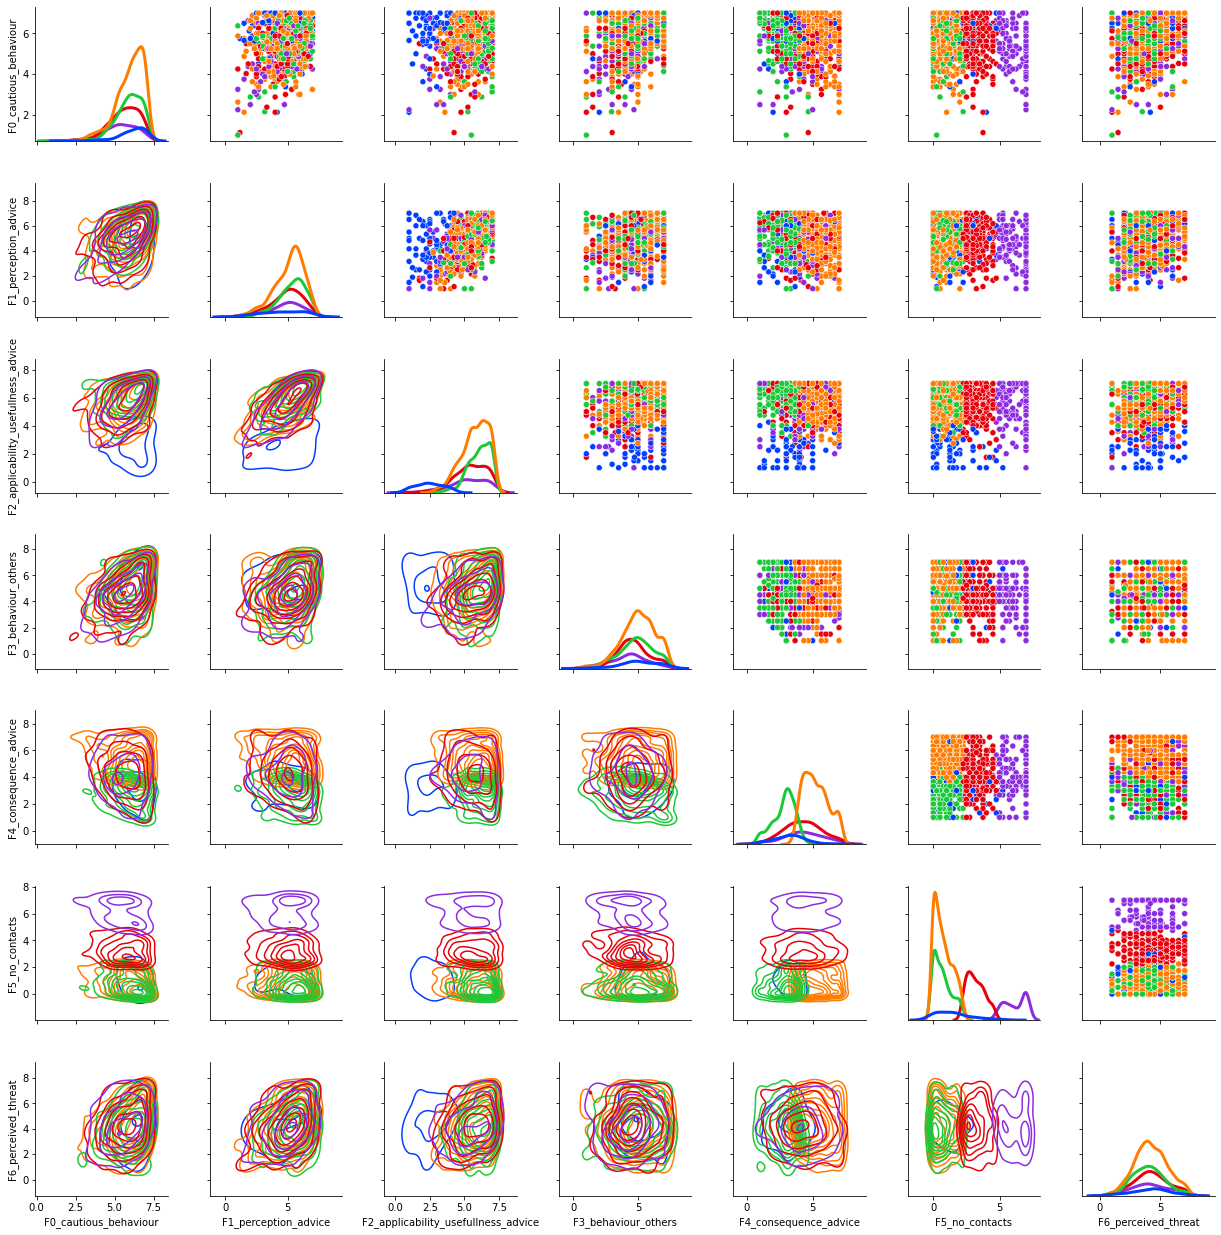

In [ ]:
%matplotlib inline
g = sns.PairGrid(data=df_sample_timewindow, vars=behaviour_cols, hue='group', palette='bright')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [ ]:
df_sample_timewindow.group = df_sample_timewindow.group.astype(str)
fig = px.scatter_3d(df_sample_timewindow, x=top_cols[0], y=top_cols[1], z=top_cols[2], color='group', opacity=1)
#fig.update_layout(
#    scene = dict(
#        xaxis = dict(nticks=5, range=[3, -3],),
#                     yaxis = dict(nticks=5, range=[3, -3],),
#                     zaxis = dict(nticks=5, range=[3, -3],),),
#        width=700, margin=dict(r=20, l=10, b=10, t=10))
fig.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Group distance # change so that it takes multiple groups into account

In [ ]:
df_dict = []
for i, day in  df[behaviour_cols + ['date', 'group']].groupby(['date']):
     groups_dist = np.abs(day[day['group']== 0].mean() - day[day['group']== 1].mean())
     dist = np.linalg.norm(groups_dist.values, ord=1)
     df_dict.append({'time':i, 'distance': dist})
dist_df = pd.DataFrame(df_dict)
dist_df['dist_smooth'] = dist_df.distance.rolling(7).mean()
fig = px.line(dist_df,x='time', y=['distance', 'dist_smooth'])
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



# Plot Group Sizes

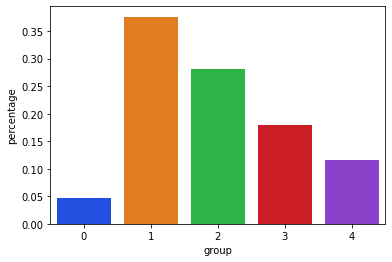

In [ ]:
df_group_size = df[['group', 'gender']].groupby('group').count().reset_index()
df_group_size['gender'] = df_group_size['gender'] / df_group_size['gender'].sum()
df_group_size.rename(columns={'gender':'percentage'}, inplace=True)
sns.barplot(data=df_group_size, x='group', y='percentage', palette='bright')

# Daily Average Group Answer

In [ ]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average.date = pd.to_datetime(df_daily_average.date)
for col in df_daily_average.columns:
    sns.lineplot(data=df_daily_average, x='date', y=col, hue='group', palette="bright")
    plt.title(col)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average_0 = df_daily_average[df_daily_average.group == 0]
df_daily_average_1 = df_daily_average[df_daily_average.group == 1]
for col in df_daily_average_0.columns:
    plt.plot(df_daily_average_0.date,df_daily_average_0[col], label='0')
    plt.plot(df_daily_average_1.date,df_daily_average_1[col], label='1')
    plt.legend()
    plt.title(col)
    plt.show()

# Observations

In [ ]:
observations = pd.read_csv('data/observations_30012022.csv',sep=';', decimal=',', encoding='utf-8')
sliced_observations = observations.iloc[92:643]
fig = px.line(sliced_observations, x="Date", y=sliced_observations.columns[2:])
fig.show()

# Archive

In [ ]:
"""for blickwinkel in np.arange(0, 270, 30):

  fig = plt.figure(figsize=(8, 8))

  ax = plt.axes(projection='3d')
  color_list = ['red', 'green', 'blue', 'yellow', 'grey']
  i=0
  x_name = top_3_cols[0]#'PC_0'
  y_name = top_3_cols[1]#'PC_3'
  z_name = top_3_cols[2]#'PC_2'
  for group in df_sample['group'].unique().tolist():
    x = df_sample[df_sample['group']==group][x_name]
    y = df_sample[df_sample['group']==group][y_name]
    z = df_sample[df_sample['group']==group][z_name]
    ax.scatter3D(x, y, z, alpha=0.1, color=color_list[i], label=str(group))
    ax.set_title('Blickwinkel: ' + str(blickwinkel) + ' Grad')
    i = i+1
  ax.legend()
  ax.set_xlabel(x_name)
  ax.set_ylabel(y_name)
  ax.set_zlabel(z_name)

  ax.azim = blickwinkel #90 #135 #180 #225 #270
  ax.elev = 40"""